**Number of editors by user edit bucket shown using voilin plot for wikis(tewiki, hiwiki, mlwiki)**

Running query on tewiki...
Running query on hiwiki...
Running query on mlwiki...


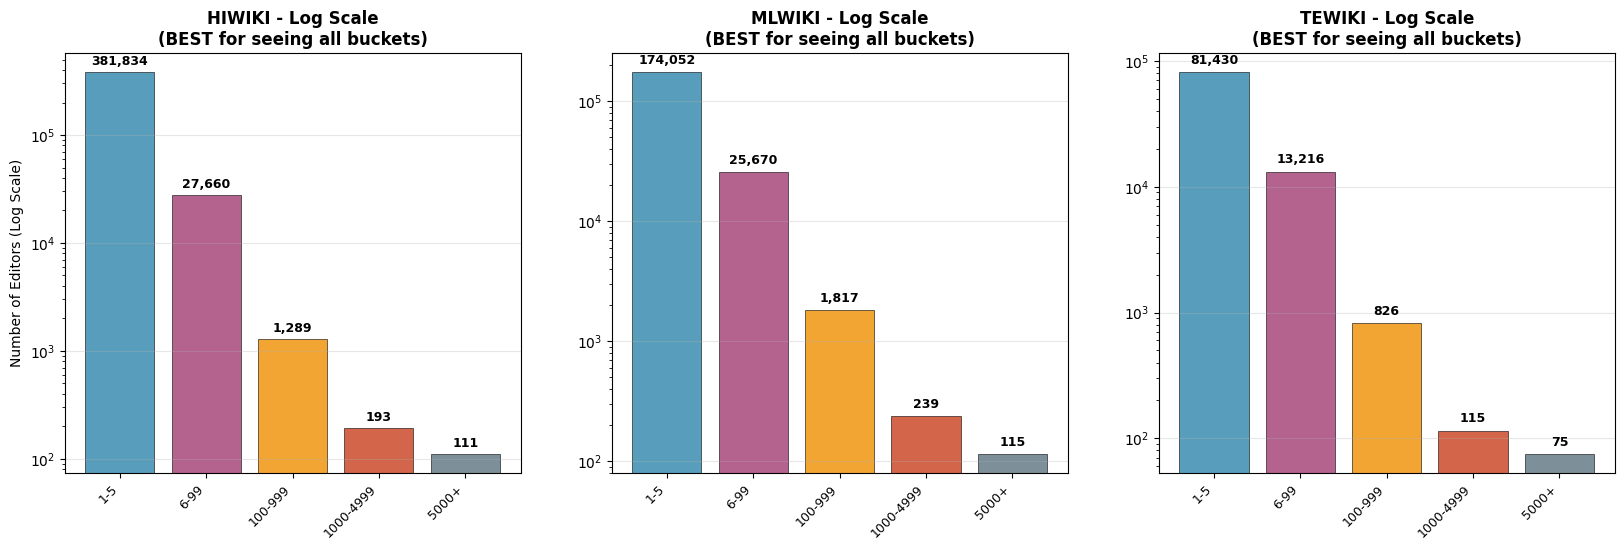

In [ ]:
# Import statements
import pymysql
import pandas as pd
import requests
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Function to connect and query
def connect_and_query(wiki_name, query, cnf_path="/home/paws/.my.cnf"):
    conn = pymysql.connect(
        host=wiki_name + '.analytics.db.svc.wikimedia.cloud',
        read_default_file=cnf_path,
        database=wiki_name + '_p'
    )
    
    with conn.cursor() as cur:
        cur.execute(query)
        data = cur.fetchall()
        colnames = [desc[0] for desc in cur.description]
    
    conn.close()
    return pd.DataFrame(data, columns=colnames)

# Define wikis and fetch SQL query 
wikis = ['tewiki', 'hiwiki', 'mlwiki']
query_url = "https://raw.githubusercontent.com/venkataeswarachi/community-insights-dashboard-tooling/main/Number_of_editors_by_user_edit_bucket.sql"
query1 = requests.get(query_url).text

# Clean sql query
query_lines = [line.strip() for line in query1.split('\n') if line.strip() and not line.strip().startswith('--')]
cleaned_query = ' '.join(query_lines)

# Iterate the query across all wikis 
all_dfs = []
for wiki in wikis:
    print(f"Running query on {wiki}...")
    df = connect_and_query(wiki, cleaned_query)
    df['wiki'] = wiki  # Label each row with its wiki source
    all_dfs.append(df)

# Combine all results into one DataFrame 
combined_df = pd.concat(all_dfs, ignore_index=True) 

# Sort combined_df by wiki alphabetically 
combined_df = combined_df.sort_values('wiki')

# Create sorted wiki list and bucket order 
wiki_order = sorted(combined_df['wiki'].unique())  

# Sort buckets by total number_of_editors (descending)
bucket_totals = combined_df.groupby('bucket')['number_of_editors'].sum()
bucket_order = bucket_totals.sort_values(ascending=False).index.tolist() 

# Color palette for consistent styling
colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D', '#5D737E', '#64A6BD', '#90A959']

# Create figure with multiple views
fig = plt.figure(figsize=(20, 12))

# 1. LOG SCALE BAR CHARTS 
for idx, wiki in enumerate(wiki_order):
    plt.subplot(2, 3, idx + 1)
    
    # Filter data for current wiki
    wiki_data = combined_df[combined_df['wiki'] == wiki]
    wiki_series = wiki_data.set_index('bucket')['number_of_editors'].reindex(bucket_order, fill_value=0)
    
    # Create bar chart with log scale
    bars = plt.bar(range(len(bucket_order)), wiki_series.values, 
                   color=colors[:len(bucket_order)], alpha=0.8, edgecolor='black', linewidth=0.5)
    
    # Set log scale
    plt.yscale('log')
    
    # Add value labels on bars
    for i, (bucket, count) in enumerate(zip(bucket_order, wiki_series.values)):
        if count > 0:
            plt.text(i, count * 1.1, f'{int(count):,}', 
                    ha='center', va='bottom', fontweight='bold', fontsize=9, rotation=0)
    
    # Customize subplot
    plt.title(f'{wiki.upper()} - Log Scale\n(BEST for seeing all buckets)', fontsize=12, fontweight='bold')
    if idx == 0:
        plt.ylabel('Number of Editors (Log Scale)', fontsize=10)
    plt.xticks(range(len(bucket_order)), bucket_order, rotation=45, ha='right', fontsize=9)
    plt.grid(True, alpha=0.3, axis='y')


Number of unique users by user right currently shown in table format for wikis (tewiki,hiwiki,mlwiki)

In [8]:
import pandas as pd
import requests
import pymysql
from tabulate import tabulate

# Function to connect and run SQL
def connect_and_query(wiki_name, query, cnf_path="/home/paws/.my.cnf"):
    """Connects to the given wiki's database and executes the provided SQL query."""
    conn = pymysql.connect(
        host=f"{wiki_name}.analytics.db.svc.wikimedia.cloud",
        read_default_file=cnf_path,
        database=f"{wiki_name}_p"
    )

    with conn.cursor() as cur:
        cur.execute(query)
        data = cur.fetchall()
        colnames = [desc[0] for desc in cur.description]

    conn.close()
    return pd.DataFrame(data, columns=colnames)


# Wikis to process
wikis = ['tewiki', 'hiwiki', 'mlwiki']


# Load SQL query from GitHub
query_url = "https://raw.githubusercontent.com/venkataeswarachi/community-insights-dashboard-tooling/main/Number_of_unique_user_by_user_right_currently.sql"
query = requests.get(query_url).text


# Storage for results
all_dfs = []
wiki_tables = {}


# Process each wiki

for wiki in wikis:
    print(f"\n{'='*60}")
    print(f" Running query on {wiki.upper()} ")
    print(f"{'='*60}")

    df = connect_and_query(wiki, query)
    df['wiki'] = wiki

    # Decode bytes in ug_group 
    if 'ug_group' in df.columns:
        df['ug_group'] = df['ug_group'].apply(
            lambda x: x.decode('utf-8') if isinstance(x, bytes) else str(x)
        )

    wiki_tables[wiki] = df
    all_dfs.append(df)

    # Printing table
    print(tabulate(df, headers="keys", tablefmt="pretty", showindex=False))



 Running query on TEWIKI 
+------------+--------------+--------+
|  ug_group  | unique_users |  wiki  |
+------------+--------------+--------+
|    bot     |      53      | tewiki |
|   sysop    |      11      | tewiki |
| bureaucrat |      4       | tewiki |
+------------+--------------+--------+

 Running query on HIWIKI 
+----------+--------------+--------+
| ug_group | unique_users |  wiki  |
+----------+--------------+--------+
|   bot    |      14      | hiwiki |
|  sysop   |      7       | hiwiki |
+----------+--------------+--------+

 Running query on MLWIKI 
+------------+--------------+--------+
|  ug_group  | unique_users |  wiki  |
+------------+--------------+--------+
|    bot     |      88      | mlwiki |
|   sysop    |      14      | mlwiki |
| bureaucrat |      2       | mlwiki |
| checkuser  |      2       | mlwiki |
+------------+--------------+--------+
